In [1]:
#imports
import numpy as np
from scipy import signal, misc, ndimage
import time, cv, os, threading, logging, json, math, matplotlib, cv2, multiprocessing
from PIL import Image, ImageGrab
import skimage
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import imageRecognition as IR
from pynput.keyboard import Key, Listener as keyboardListener
from pynput.mouse import Button as mouseButton, Controller as mouseController, Listener as mouseListener

logging.basicConfig(level=logging.INFO,
#filename= 'output.txt',
format='%(asctime)s - %(levelname)s - %(message)s')
logging.debug("Start of program")
#logging.disable(logging.CRITICAL)  #end all logging messages

2019-11-14 17:36:54,347 - DEBUG - Start of program
2019-11-14 17:36:54,362 - DEBUG - Start of program
2019-11-14 17:36:54,364 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
#see distribution of pixel colours
#plt.hist(npImz[1].ravel(), bins=256, range=[0,255])
print()

In [2]:
#display whatever info wanted via cv2 window
while True:
    #image
    imz = ImageGrab.grab()
    npImz = np.array(imz)
    finalImz = cv2.cvtColor(npImz, cv2.COLOR_BGR2GRAY)
 
    h,w = finalImz.shape
    finalDim = (w//2, h//2)
    resizedImage = cv2.resize(finalImz, finalDim, fx=0.5,fy=0.5)
    cv2.imshow('frame',resizedImage)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [3]:
#display dota map in separate window
def mapWindow(secondaryMonitorSize=(2560,1440)):
    #mapBox = 0,1116,324,1440
    mapBox = 24, 1090, 315, 1400
    while True:
        #capture map image
        imz = ImageGrab.grab(bbox=mapBox)
        npImz = np.array(imz)
        finalImz = cv2.cvtColor(npImz,cv2.COLOR_BGR2RGB)
        #resize image
        #h,w,_ = npImz.shape
        #scale = 0.5
        #fx = secondaryMonitorSize[0] * scale / w
        #fy = secondaryMonitorSize[1] * scale / h
        #resizedImage = cv2.resize(npImz, secondaryMonitorSize, fx=fx, fy=fy)
        #show image
        windowName = "Dota Map"
        cv2.namedWindow(windowName, flags=cv2.WINDOW_NORMAL)
        #cv2.imshow(windowName, resizedImage)
        cv2.imshow(windowName, finalImz)
        #if closed, terminate image
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
mapWindow()

In [33]:
#albion screen test on a separate window
deltaTimes = []
#default kernel
siz = 10
kernel = np.ones((siz,siz),np.uint8)
mouse = mouseController()
def myLine(pos, center=(1280,720), offset=100):
    dy = center[1] - pos[1]
    dx = center[0] - pos[0]
    m = dy/dx
    #abandoned
def circlePos(point, center, resolution, r=None):
    px,py = point
    cx, cy = center
    if not r:
        r = max(resolution)
    rad = math.atan2(py-cy, px-cx)
    x = (r * math.cos(rad)) + cx
    y = (r * math.sin(rad)) + cy
    return int(x), int(y)
    
def mapWindow(option=1, WindowName='idgaf'):
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows = False)
    print(dir(fgbg))
    #fgbg = cv2.createBackgroundSubtractorKNN()
    #https://docs.opencv.org/master/de/de1/group__video__motion.html
    if option == 3:
        fgbg = cv2.createBackgroundSubtractorMOG2(history=5, varThreshold=50, detectShadows = False)
    if option == 4:
        fgbg = cv2.createBackgroundSubtractorMOG2(history=10, varThreshold=1, detectShadows = False)
    while True:
        st = time.monotonic()
        #capture map image
        if option == 1:
            imz = ImageGrab.grab()
            npImz = np.array(imz)
            finalImz = cv2.cvtColor(npImz,cv2.COLOR_BGR2GRAY)
            windowName = "Blacked"
        elif option == 2:
            imz = ImageGrab.grab()
            npImz = np.array(imz)
            finalImz = fgbg.apply(npImz)
            windowName = "Blacked"
        elif option == 3:
            #testing albion bobbin recognition
            imz = ImageGrab.grab()
            npImz = np.array(imz)
            #mask1
            preMask1 = np.zeros_like(npImz)
            finalPoint = circlePos(mouse.position, (1280,720), (2560,1440))
            cv2.line(preMask1, (1280,720), finalPoint, (255,255,255), 200)
            mask1 = preMask1[:,:,0]
            #mask2
            hsv = cv2.cvtColor(npImz, cv2.COLOR_RGB2HSV)
            lowSat, lowValue, maxCh = 100, 100, 256
            lowerHSVRed = np.array([0,lowSat,lowValue])
            upperHSVRed = np.array([5, 256, 256])
            lowerHSVBlue = np.array([160, lowSat, lowValue])
            upperHSVBlue = np.array([181, 256, 256])
            #cv2 hsv range: h(0-180), s(0-255), v(0-255)
            maskGradualRed = cv2.inRange(hsv, lowerHSVRed, upperHSVRed)
            maskGradualBlue = cv2.inRange(hsv, lowerHSVBlue, upperHSVBlue)
            mask2 = cv2.bitwise_or(maskGradualRed, maskGradualBlue)
            #mask3
            mask3 = fgbg.apply(npImz)
            #final mask
            finalImz = cv2.bitwise_and(mask1, mask2, mask3)
            #labels
            countNum, labels = cv2.connectedComponents(finalImz)
            unique, counts = np.unique(labels, return_counts=True)
            counts = counts.tolist()
            if countNum > 1:
                indices = range(countNum)
                #https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
                sortedIndices = [x for _,x in sorted(zip(counts,indices))]
                maxSizeIndex = sortedIndices[-2]
                #text = str(ndimage.center_of_mass(finalImz, labels=labels, index=maxSizeIndex))
                text = str(counts)
                finalImz = cv2.inRange(labels, (maxSizeIndex,), (maxSizeIndex,))
                cv2.putText(finalImz, text, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255), lineType=cv2.LINE_AA) 
            windowName = 'Drawing'
        elif option == 4:
            #albion dynamic background
            imz = ImageGrab.grab()
            npImz = np.array(imz)
            mask = fgbg.apply(npImz)
            #finalImz = ndimage.binary_closing(mask)
            finalImz = mask
            text = str(ndimage.standard_deviation(mask))
            cv2.putText(finalImz, text, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255), lineType=cv2.LINE_AA) 
            windowName = "Blacked"
            time.sleep(2)
        elif option == 5:
            #albion water detect
            #screenshot
            imz = ImageGrab.grab()
            npImz = np.array(imz)
            #hsv = cv2.cvtColor(npImz, cv2.COLOR_RGB2HSV)
            gray = cv2.cvtColor(npImz, cv2.COLOR_RGB2GRAY)
            #MASK
            #colour ranges
            lowerHSVBlue = np.array([100, 50, 50])
            upperHSVBlue = np.array([140, 256, 256])
            #mask = cv2.inRange(hsv, lowerHSVBlue, upperHSVBlue)
            
            #threshold gradient 
            #(thresh, mask) = cv2.threshold(grayGradient, 10, 255, cv2.THRESH_BINARY)
            grayDenoise = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
            #morphology: https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=morphologyex#cv2.morphologyEx
            mask = cv2.adaptiveThreshold(grayDenoise,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
            #adaptive thresholding: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
            #mask = cv2.adaptiveThreshold(grayDenoise,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
            
            #labels
            ret, labels = cv2.connectedComponents(mask)
            #labels, num_features = ndimage.label(mask)
            #counts = np.bincount(labels)
            #vals, counts = np.unique(mask, return_counts=True)
            #print(counts)
            finalImz = mask
            text = str(ndimage.standard_deviation(mask))
            #cv2.putText(finalImz, text, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255), lineType=cv2.LINE_AA) 
            windowName = "Water"
        #show image
        cv2.namedWindow(windowName, flags=cv2.WINDOW_NORMAL)
        cv2.imshow(windowName, finalImz)
        #if closed, terminate image
        deltaTimes.append(time.monotonic() - st)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    print("Average:", sum(deltaTimes)/len(deltaTimes), "Minimum:", min(deltaTimes), "Maximum:", max(deltaTimes))
    
mapWindow(3, 'idgaf')

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'apply', 'clear', 'empty', 'getBackgroundImage', 'getBackgroundRatio', 'getComplexityReductionThreshold', 'getDefaultName', 'getDetectShadows', 'getHistory', 'getNMixtures', 'getShadowThreshold', 'getShadowValue', 'getVarInit', 'getVarMax', 'getVarMin', 'getVarThreshold', 'getVarThresholdGen', 'read', 'save', 'setBackgroundRatio', 'setComplexityReductionThreshold', 'setDetectShadows', 'setHistory', 'setNMixtures', 'setShadowThreshold', 'setShadowValue', 'setVarInit', 'setVarMax', 'setVarMin', 'setVarThreshold', 'setVarThresholdGen', 'write']
Average: 0.24183660130721465 Minimum: 0.21799999999348074 Maximum: 0.5459999999948195


In [27]:
#circle detection with cv2
import cv2
import numpy as np

#img = cv2.imread('opencv_logo.png',0)
img = ImageGrab.grab()
img = np.array(img)[0]
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,param1=50,param2=30,minRadius=10,maxRadius=500)
print(circles)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

cv2.imshow('detected circles',cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html#hough-circles

None


AttributeError: 'NoneType' object has no attribute 'rint'

In [57]:
#image correlation with cv2
st = time.monotonic()

box = (400,15,660,70)
imz = ImageGrab.grab()
npImz = np.array(imz)

#several templates
#npTemplate = cv2.imread(r"C:\Users\Administrator\Pictures\albion enemy hp bar.png")
#npTemplate = cv2.imread(r"C:\Users\Administrator\Pictures\albion stun icon.png")
#npTemplate = cv2.imread(r"C:\Users\Administrator\Pictures\albion stun bar.png")
#npTemplate = cv2.imread(r"C:\Users\Administrator\Pictures\albaion enemy tag.png")
#npTemplate = cv2.imread(r"C:\Users\Administrator\Dropbox\Python Codes\float in water.jpg")
npTemplate = cv2.imread(r"C:\Users\Administrator\Pictures\albion float1.png")
npTemplate = cv2.cvtColor(npTemplate, cv2.COLOR_BGR2RGB)
#scan to hsv
npScan = npImz
#npScan = skimage.color.rgb2hsv(npScan).astype('uint8')
#npTemplate = skimage.color.rgb2hsv(npTemplate).astype('uint8')
print(npScan.dtype)

checkChannel = 0
h,w = npTemplate[:,:,0].shape

res = cv2.matchTemplate(npScan[:,:,checkChannel], npTemplate[:,:,checkChannel], cv2.TM_CCOEFF_NORMED)
#res = cv2.matchTemplate(npScan, npTemplate, cv2.TM_CCOEFF_NORMED)
print(time.monotonic() - st, "time it took")
maxLoc = np.unravel_index(np.argmax(res), res.shape)
print(maxLoc,"Where best was located")

threshold = 0.6
displayImage = cv2.cvtColor(npScan, cv2.COLOR_BGR2RGB)
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(displayImage, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
print(loc[0].size, "How many detected")
print(np.max(res), "max value")
cv2.imshow('goat',displayImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

uint8
0.24899999999979627 time it took
(1219, 1973) Where best was located
0 How many detected
0.5135467 max value


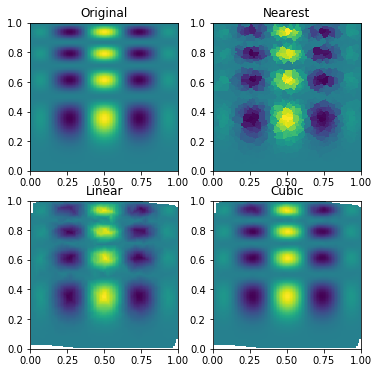

(1000,)
(100, 200)


In [162]:
#scipy grid creation and something
from scipy.interpolate import griddata
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
#plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()
print(values.shape)
print(grid_z0.shape)

Counts [-15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]
15
(0.0, 1995.0)
End time 1.1240000000034343


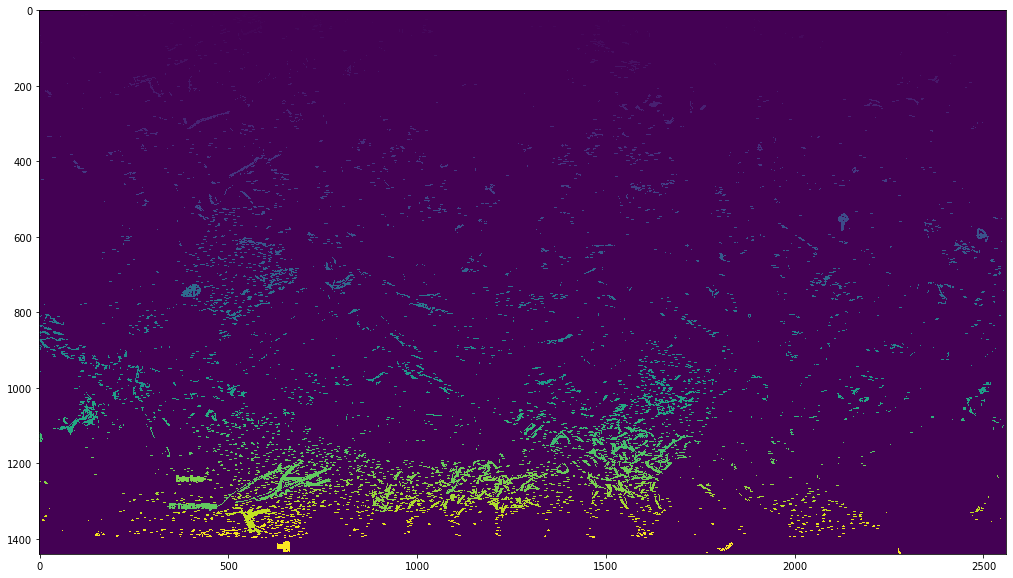

In [77]:
st = time.monotonic()
imz = ImageGrab.grab()
npImz = np.array(imz)
#hsvImz = skimage.color.rgb2hsv(npImz)
npGradient = ndimage.gaussian_gradient_magnitude(npImz[:,:,0], 1)
npGradientColour = npGradient * 255
npGradientBit = npGradientColour.astype('int8')
labeled, n = ndimage.label(npGradientBit)
u, counts = np.unique(npGradientBit, return_counts=True)
print("Counts", counts)
clusterInd = list(counts).index(np.max(counts))
print(clusterInd)
ans = np.where(labeled==(clusterInd), 255, 0)
print(ndimage.center_of_mass(ans))

print("End time", time.monotonic() - st)
#pic = Image.fromarray(npGradient*n)
pic = Image.fromarray(ans)
plt.imshow(labeled)
plt.show()
pic.show()

In [16]:
#test for horizontal axis in albion
#incomplete but 690 out of resolution of 1440 for horizontal axis (CLOSE TO 720)
y = np.arange(500,1000,50)
x = np.arange(100,200)
mouse = mouseController()
box = (0,0,1000,1200)

def diffCalc(juan, deux):
    diff = deux - juan
    hsvImg = skimage.color.rgb2hsv(deux)
    #hImg = hsvImg[:,:,0]
    npSumZ = np.sum(diff,axis=2)
    validImg = where(npSumZ>100,hsvImg,np.max(hsv))
    redPoints = where((hsvImg[:,:,0]<0.05)&(hsvImg[:,:,0]>0.95))
    
    # the histogram of the data
    ax.hist(npSumZ.flatten(), 100, density=1)
    #plt.hist([linaire, linaire2], bins, label=['r', 'h'])
    plt.show()

'''for why in y:
    for ex in x:
        before = ImageGrab.grab(bbox=box)
        npBefore = np.array(before)
        mouse.position = (x,y)
        mouse.press(mouseButton.left)
        time.sleep(1)
        mouse.release(mouseButton.left)
        after = ImageGrab.grab(bbpx=box)'''

    

'for why in y:\n    for ex in x:\n        before = ImageGrab.grab(bbox=box)\n        npBefore = np.array(before)\n        mouse.position = (x,y)\n        mouse.press(mouseButton.left)\n        time.sleep(1)\n        mouse.release(mouseButton.left)\n        after = ImageGrab.grab(bbpx=box)'

In [14]:
#my cluster detection
def clusterFind(reservoir, threshold = 1):
    #reservoir - list of tuple pairs representing coordinates
    def diff(tup1, tup2):
        #returns true or not if tuples are within thresshold magnitude
        ind = range(len(tup1))
        c2 = sum(((tup1[i] - tup2[i])**2) for i in ind) #pythoagoras theorem
        return False if c2 > threshold**2 else True
    #container for each cluster found
    clusters = []
    while len(reservoir) > 0:
        first = reservoir.pop()
        activeCluster = [first]
        checkNum = 0
        while checkNum < len(activeCluster):
            tester = activeCluster[checkNum]
            for henny in reservoir:
                if diff(tester, henny):
                    activeCluster.append(henny)
                    reservoir.remove(henny)
            checkNum += 1
        clusters.append(activeCluster)
    return clusters
    logging.debug(len(clusters))

10 Amount of passables.


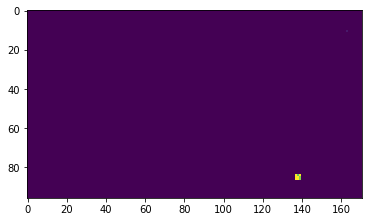

0.16499999999723514 duration
2 amount of clusters
Quantity in each cluster
9
1


In [147]:
#the difference between two images and calculation of clusters
st = time.monotonic()
pauseDuration = 4
#box = (0,0,200,200)
box = (0,0,2559,1439)
firstImage = ImageGrab.grab(bbox=box)
time.sleep(pauseDuration)
secondImage = ImageGrab.grab(bbox=box)

step = 15
np1stPre = np.array(firstImage)
np2ndPre = np.array(secondImage)
np1st = np1stPre[0:-1:step, 0:-1:step, :]
np2nd = np2ndPre[0:-1:step, 0:-1:step, :]
diff = np2nd - np1st
metric = np.absolute(diff[:,:,0])
#metric = diff

underwear = np.where(metric > 0)
y,x = underwear
lister = [(x[i],y[i]) for i in range(len(x))]
print(len(lister), "Amount of passables.")
clusters = clusterFind(lister, threshold=2)

duration = time.monotonic() - st
fig, ax = plt.subplots()
im = ax.imshow(metric)
plt.show()

print(duration - pauseDuration, "duration")

if isinstance(clusters, (tuple, list, np.ndarray)):
    print(len(clusters), "amount of clusters")
    print('Quantity in each cluster')
    for clus in clusters:
        print(len(clus))
else:
    print(clusters)


2019-09-26 23:11:59,687 - DEBUG - STREAM b'IHDR' 16 13
2019-09-26 23:11:59,692 - DEBUG - STREAM b'sRGB' 41 1
2019-09-26 23:11:59,693 - DEBUG - STREAM b'gAMA' 54 4
2019-09-26 23:11:59,695 - DEBUG - STREAM b'pHYs' 70 9
2019-09-26 23:11:59,696 - DEBUG - STREAM b'IDAT' 91 2175


255 maxi 105 location 97.8692628034854 deviation 0.0 median 0.0 time to finish


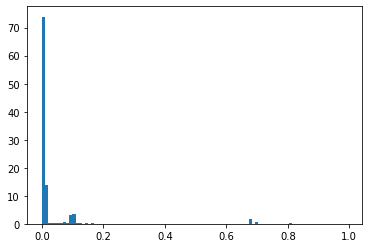

In [73]:
#image colour distributions
st = time.monotonic()
img = Image.open(r"C:\Users\Administrator\Dropbox\Python Codes\float in water.jpg")
#if red over 80, its the float (mostlikely) or do it according to percentile
#step check of 15-20 can be used
npImg = np.array(img)
hsvImg = skimage.color.rgb2hsv(npImg)
npChannel = npImg[:,:,0]
hsvChannel = hsvImg[:,:,0]
#booly = np.where((hsvImg[:,:,2]>0.1)&(hsvImg[:,:,0]<0.1)&(hsvImg[:,:,1]>0.5), 1, 0)
booly = np.where((hsvImg[:,:,2]>0.1)&(hsvImg[:,:,0]<0.1), hsvImg[:,:,2], np.mean(hsvImg[:,:,2]))
linaire = npChannel.flatten()
linaire2 = hsvChannel.flatten()
#linaire2 = np.where(hsvImg[:,:,2]>0.1, hsvChannel, 2).flatten()
maxi = np.max(linaire)
wear = np.where(linaire==maxi)
stdz = np.std(linaire)
median = np.median(linaire)
duration = time.monotonic()-st
print(maxi, "maxi", wear[0].size, "location", stdz, "deviation", median, "median", duration, "time to finish")

fig, ax = plt.subplots()

# the histogram of the data
ax.hist(linaire2, 100, density=1)
#plt.hist([linaire, linaire2], bins, label=['r', 'h'])
plt.show()
im = Image.fromarray(booly * 255)
im.show()

224 maxi 2 location 27.453888055132964 deviation 116.0 median 0.10899999999855936 time to finish


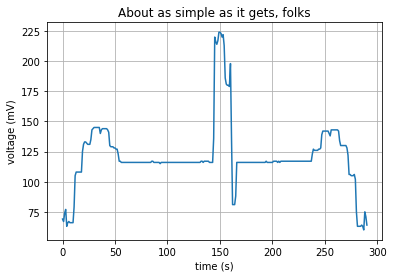

In [49]:
#fishing balance tester
#box = (1190,736,1370,737)
box = (1134, 736, 1425, 737)
#box = (1180, 823, 1380, 824)
st = time.monotonic()
img = Image.open(r"C:\Users\Administrator\Pictures\albion work with.png")
partImg = img.crop(box)
npImg = np.array(partImg)
linaire = npImg[:,:,1].flatten()
maxi = np.max(linaire)
wear = np.where(linaire==maxi)
stdz = np.std(linaire)
median = np.median(linaire)
duration = time.monotonic()-st
print(maxi, "maxi", wear[0].size, "location", stdz, "deviation", median, "median", duration, "time to finish")

fig, ax = plt.subplots()
ax.plot(linaire)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()
plt.show()

In [4]:
import win32gui, win32api, win32con, ctypes, time, os, random
import numpy as np
from gta5Help import *

class Mouse:
    """It simulates the mouse"""
    MOUSEEVENTF_MOVE = 0x0001 # mouse move 
    MOUSEEVENTF_LEFTDOWN = 0x0002 # left button down 
    MOUSEEVENTF_LEFTUP = 0x0004 # left button up 
    MOUSEEVENTF_RIGHTDOWN = 0x0008 # right button down 
    MOUSEEVENTF_RIGHTUP = 0x0010 # right button up 
    MOUSEEVENTF_MIDDLEDOWN = 0x0020 # middle button down 
    MOUSEEVENTF_MIDDLEUP = 0x0040 # middle button up 
    MOUSEEVENTF_WHEEL = 0x0800 # wheel button rolled 
    MOUSEEVENTF_ABSOLUTE = 0x8000 # absolute move 
    SM_CXSCREEN = 0
    SM_CYSCREEN = 1

    def _do_event(self, flags, x_pos, y_pos, data, extra_info):
        """generate a mouse event"""
        x_calc = 65536 * x_pos / ctypes.windll.user32.GetSystemMetrics(self.SM_CXSCREEN) + 1
        y_calc = 65536 * y_pos / ctypes.windll.user32.GetSystemMetrics(self.SM_CYSCREEN) + 1
        return ctypes.windll.user32.mouse_event(flags, x_calc, y_calc, data, extra_info)

    def _get_button_value(self, button_name, button_up=False):
        """convert the name of the button into the corresponding value"""
        buttons = 0
        if button_name.find("right") >= 0:
            buttons = self.MOUSEEVENTF_RIGHTDOWN
        if button_name.find("left") >= 0:
            buttons = buttons + self.MOUSEEVENTF_LEFTDOWN
        if button_name.find("middle") >= 0:
            buttons = buttons + self.MOUSEEVENTF_MIDDLEDOWN
        if button_up:
            buttons = buttons << 1
        return buttons

    def move_mouse(self, pos):
        """move the mouse to the specified coordinates"""
        (x, y) = pos
        old_pos = self.get_position()
        x =  x if (x != -1) else old_pos[0]
        y =  y if (y != -1) else old_pos[1]    
        self._do_event(self.MOUSEEVENTF_MOVE + self.MOUSEEVENTF_ABSOLUTE, x, y, 0, 0)

    def press_button(self, pos=(-1, -1), button_name="left", button_up=False):
        """push a button of the mouse"""
        self.move_mouse(pos)
        self._do_event(self.get_button_value(button_name, button_up), 0, 0, 0, 0)

    def click(self, pos=(-1, -1), button_name= "left"):
        """Click at the specified placed"""
        self.move_mouse(pos)
        self._do_event(self._get_button_value(button_name, False)+self._get_button_value(button_name, True), 0, 0, 0, 0)

    def double_click (self, pos=(-1, -1), button_name="left"):
        """Double click at the specifed placed"""
        for i in xrange(2): 
            self.click(pos, button_name)

    def get_position(self):
        """get mouse position"""
        return win32api.GetCursorPos()
    
    def mane(self):
        #mouse positions
        
        #load in images
        imageDir = os.path.join(os.getcwd(), 'game resources')
        buyPath = os.path.join(imageDir, "gta 5 bunker buy supplies.png")
        surePath = os.path.join(imageDir, "gta 5 bunker confirm.png")
        buyTemplate = cv2.cvtColor(cv2.imread(buyPath), cv2.COLOR_BGR2RGB)
        sureTemplate = cv2.cvtColor(cv2.imread(surePath), cv2.COLOR_BGR2RGB)
        #time management
        timeKeep = 0
        sleepLimit = 3 * 60 * 60
        timeInterval = 3 * 60
        while True:
            #wait 3 hours
            while timeKeep < sleepLimit:
                #move mouse
                pos = (random.randint(1, 500), random.randint(1, 500))
                print(pos)
                self.move_mouse(pos)
                #delay sleep time
                timeKeep += timeInterval
                time.sleep(timeInterval)
            else:
                timeKeep = 0
            #buy setup
            scan = np.array(ImageGrab.grab(bbox=boxLocation))
            sleep(5)
            #buy supplies
            buyMatch = cv2.matchTemplate(scan, buyTemplate)
            buyPoint = maxLocation(buyMatch)
            self.click(pos=buyPoint.tolist())
            time.sleep(20)
            #confirm
            sureMatch = cv2.matchTemplate(scan, sureTemplate)
            surePoint = maxLocation(sureMatch)
            self.click(pos=surePoint.tolist())
            time.sleep(20)

obj = Mouse()
obj.mane()
    

(103, 207)


ArgumentError: argument 2: <class 'TypeError'>: Don't know how to convert parameter 2

In [61]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 